In [1]:
import numpy as np
import pandas as pd
from numba import jit, vectorize, float64, types, int64, prange
import numba
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm.notebook import trange, tqdm
from scipy.spatial.transform import Rotation
from scipy.sparse import dia_matrix
from scipy.optimize import minimize
from datetime import datetime
from qutip import sigmax, sigmay, sigmaz, jmat
import time
import h5py
from labellines import labelLine, labelLines
from time import sleep
import scipy
from adjustText import adjust_text
import matplotlib.animation as animation

In [2]:
from spin_reconstruction.constants import *

In [12]:
file = "reconstructed_fine_random_300_constrained_nb.hdf5"
couplings_file = "fine_couplings_nb_full_B_0.hdf5"
scipy.stats.mstats.gmean(-erbium_gamma[1:] / gamma_w)

np.float64(25196.76868192088)

# State reconstruction

In [13]:
@jit
def index_to_coord(index, max_distance, site_nb):
    center = max_distance // 2
    return (
            index // (max_distance**2 * site_nb) - center,
            index // (max_distance * site_nb) % max_distance - center,
            index // site_nb % max_distance - center,
            index % site_nb
        )

@jit
def coord_to_index(vec, max_distance, site_nb):
    center = max_distance // 2
    return (
                            (
                                (
                                    (vec[0] + center)*max_distance + (vec[1] + center)
                                )*max_distance
                                + (vec[2] + center)
                            )*site_nb
                            + vec[3]
                       
       )


@jit
def compute_dr(i, size, distance):
    center = size // 2
    x = i // (size**2) - center
    y = (i // size) % size - center
    z = i % size - center
    return np.array([x, y, z]) * distance

def compute_all_dr(data, size, distance):
    rslt = np.empty((*data.shape,3))
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            rslt[i, j] = compute_dr(data[i, j], size, distance)
    return rslt



In [14]:
 
# https://stackoverflow.com/questions/11649577/how-to-invert-a-permutation-array-in-numpy
def invert_permutation(p):
    """Return an array s with which np.array_equal(arr[p][s], arr) is True.
    The array_like argument p must be some permutation of 0, 1, ..., len(p)-1.
    """
    p = np.asanyarray(p) # in case p is a tuple, etc.
    s = np.empty_like(p)
    s[p] = np.arange(p.size)
    return s

###  Load data

In [15]:
from measurement_data import data_header, renormalized_data, a_par_data, nb_par_data, WW_sigma

### Compute

In [16]:
with (
    h5py.File(file, "r") as g,
    h5py.File(couplings_file, "r") as f
):
    permutation_inv = invert_permutation(g["permutation"][:])
    permutation = g["permutation"][:]
    config = g.attrs["config"]
    print(config)
    max_distance = f.attrs["max_distance"]
    base_sites = np.array([index_to_coord(c, max_distance, site_nb) for c in config])
    base_positions = lattice_x[None,:]*base_sites[:,0][:,None] + lattice_y[None,:] * base_sites[:,1][:,None] + lattice_z[None,:] * base_sites[:,2][:,None] + lattice_s[base_sites[:,3]]
    if "selected_sites" in g.attrs:
        selected_sites = g.attrs["selected_sites"]
    else:
        selected_sites = np.arange(len(base_sites))
    size = g.attrs["size"]
    step = g.attrs["distance"]
    all_displacements_index = g["sites"][:]
    all_displacements = compute_all_dr(all_displacements_index, size, g.attrs["distance"])
    #all_errors = g["errors"][:]
    couplings = {
        (i, j): (np.array(f[f"/SEDOR_couplings/{i}_{j}"][:], dtype=np.float64))
            for j in range(len(a_par_data))
            for i in range(len(a_par_data))
            if f"/SEDOR_couplings/{i}_{j}" in f
    }
    a_par = np.array([f[f"A_par_couplings/{i}"][:] for i in range(len(a_par_data))])
    nb_par = np.array([f[f"Nb_par_couplings/{i}"][:] for i in range(len(a_par_data))])


    title = f"{len(all_displacements_index)} randomized reconstruction."

[1459 1784 1169 1136 1133 2107 1816 1497 1460]


In [17]:
positions = all_displacements[:,permutation_inv] + base_positions[selected_sites]
print(title)
positions.shape, all_displacements[:,permutation_inv].shape, all_displacements_index.shape, base_positions[selected_sites].shape

300 randomized reconstruction.


((300, 9, 3), (300, 9, 3), (300, 9), (9, 3))

# Results overview

### Reconstruction visualisations

In [18]:
def apply_full_rot(p, x):
    return Rotation.from_rotvec(x[6:9]).apply(p-x[0:3]*1e-9) + x[3:6]*1e-9

def rotate_and_translate(position, target):
    def rt(x, p, t):
        return np.sum(np.array([1,1,1,1,1,1,1,1,1])[:,None]*(apply_full_rot(p, x) - t)**2)*1e21
    return minimize(rt, np.array([0]*9), args=(position,target))


In [19]:
rotate_and_translate(positions[0,:,:], positions[200,:,:])



  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 148.603315028451
        x: [ 8.866e-02 -5.600e-02 -1.300e-01  1.375e-01 -8.180e-02
            -7.163e-02 -9.259e-02 -3.329e-02  5.358e-02]
      nit: 17
      jac: [ 1.028e-03 -2.056e-03  3.431e-03 -7.591e-04  1.947e-03
            -3.386e-03 -5.079e-03  4.171e-03  3.147e-04]
 hess_inv: [[ 4.358e-01  1.769e-01 ... -2.519e-03  1.677e-03]
            [ 1.769e-01  9.264e-02 ... -1.256e-03  8.375e-04]
            ...
            [-2.519e-03 -1.256e-03 ...  1.489e-04 -3.103e-05]
            [ 1.677e-03  8.375e-04 ... -3.103e-05  2.153e-04]]
     nfev: 601
     njev: 59

059

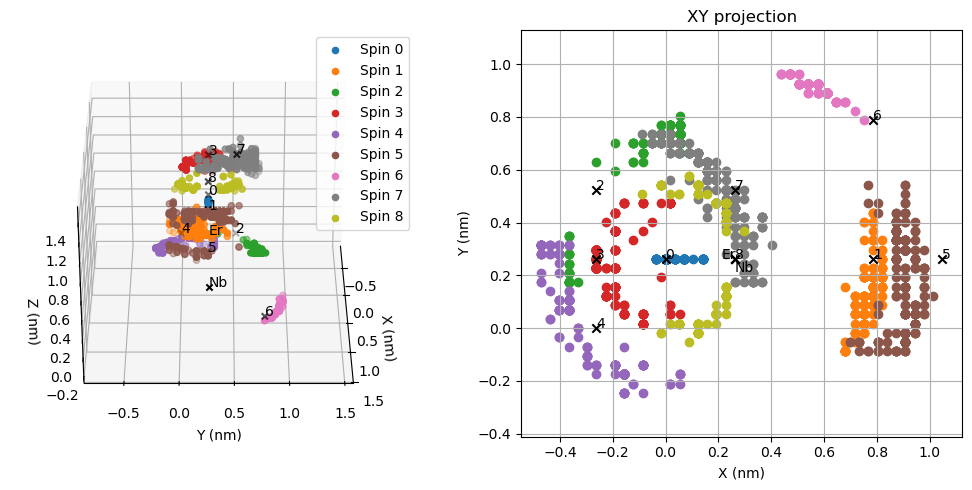

In [20]:
%matplotlib inline
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1,projection='3d')
show_pink = True
new_pos = np.empty(positions.shape)
rot = np.empty((positions.shape[0], 9))


er = np.array([0.5*a, 0.5*a, 0.5*c])
nb = np.array([0.5*a, 0.5*a, 0])
rot_er = np.empty((300,3))
rot_nb = np.empty((300,3))
for i in range(len(new_pos)):
    r = rotate_and_translate(positions[i,:,:], positions[0,:,:]).x
    new_pos[i] = (positions[i,:,:])*1e9
    rot_er[i] = apply_full_rot(er, r)
    rot_nb[i] = apply_full_rot(nb, r)
    rot[i] = r
rot_er = np.array([er])
rot_nb = np.array([nb])

artists = []

for i in range(positions.shape[1]):
    artists.append(ax.scatter(new_pos[:,i,0].flatten(), new_pos[:,i,1].flatten(), new_pos[:,i,2].flatten(), label=f"Spin {i}"))
if show_pink: artists.append(ax.scatter(base_positions[:,0]*1e9, base_positions[:,1]*1e9, base_positions[:,2]*1e9, color="black", marker = "x", zorder = 1000))

artists.append(ax.scatter(rot_er[:,0]*1e9, rot_er[:,1]*1e9, rot_er[:,2]*1e9, color="black", marker = "x", zorder = 1000))
artists.append(ax.scatter(rot_nb[:,0]*1e9, rot_nb[:,1]*1e9, rot_nb[:,2]*1e9, color="black", marker = "x", zorder = 1000))

for i in range(len(base_positions)):
    if show_pink: artists.append(ax.text(base_positions[i,0]*1e9, base_positions[i,1]*1e9, base_positions[i,2]*1e9, str(i), color="black", zorder = 1000))
if show_pink: artists.append(ax.text(er[0]*1e9, er[1]*1e9, er[2]*1e9, "Er", color="black", zorder = 1000))
if show_pink: artists.append(ax.text(nb[0]*1e9, nb[1]*1e9, nb[2]*1e9, "Nb", color="black", zorder = 1000))



ax.set_xlabel('X (nm)')
ax.set_ylabel('Y (nm)')
ax.set_zlabel('Z (nm)')

ax.legend()
ax.axis('equal')

ax3d = ax


ax = fig.add_subplot(1,2,2)


for i in range(positions.shape[1]):
    ax.scatter(new_pos[:,i,0].flatten(), new_pos[:,i,1].flatten(), label=f"Spin {i}")
if show_pink: ax.scatter(base_positions[:,0]*1e9, base_positions[:,1]*1e9, color="black", marker = "x", zorder = 1000)

ax.scatter(rot_er[:,0]*1e9, rot_er[:,1]*1e9, color="black", marker = "x", zorder = 1000)
ax.scatter(rot_nb[:,0]*1e9, rot_nb[:,1]*1e9, color="black", marker = "x", zorder = 1000)

for i in range(len(base_positions)):
    if show_pink: ax.text(base_positions[i,0]*1e9, base_positions[i,1]*1e9, str(i), color="black", zorder = 1000)
if show_pink: ax.text((er[0])*1e9-0.05, er[1]*1e9, "Er", color="black", zorder = 1000)
if show_pink: ax.text(nb[0]*1e9, (nb[1])*1e9-0.05, "Nb", color="black", zorder = 1000)


ax.set_xlabel('X (nm)')
ax.set_ylabel('Y (nm)')

ax.set_title("XY projection")

ax.grid()
ax.axis('equal')

fig.tight_layout()
#fig.savefig("random_reco.svg")



def animate(i):
    ax3d.view_init(azim=i)
    print(i, end = "\r")
    return (*artists,)


ani = animation.FuncAnimation(fig, animate, repeat=True, frames=360, interval=50)
writer = animation.FFMpegWriter(fps=15,
                                #metadata=dict(artist='Me'),
                                #bitrate=1800
                               )


ani.save('random_reco.mp4', writer=writer)
pass

IndexError: index 9 is out of bounds for axis 1 with size 9

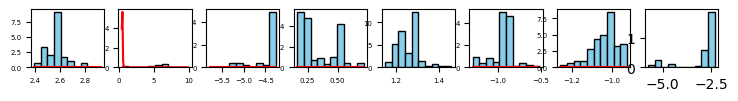

In [27]:
num_cols = len(a_par_data)

# Create figure and axes
fig = plt.figure(figsize=(10, 8))

# Plot each histogram in its respective subplot
for i in range(num_cols**2):
    y = i % num_cols
    x = i // num_cols
    if (x, y) not in couplings:
        continue
    ax = fig.add_subplot(num_cols, num_cols, i+1)
    cc = np.array([couplings[(x, y)][all_displacements_index[j,permutation_inv[x]],all_displacements_index[j,permutation_inv[y]]] for j in range(len(all_displacements_index))])
    #print(len(cc))
    _, bins, _ = ax.hist(cc, density = True, bins = 10,color='skyblue', edgecolor='black')
    xx = np.linspace(np.min(cc), np.max(cc), 100)
    ax.plot(xx, 1/np.sqrt(2*np.pi*WW_sigma[x, y]**2)*np.exp(-(xx-renormalized_data[x, y])**2/(2*WW_sigma[x, y]**2)), color = "red")
    ax.tick_params(axis='both', which='major', labelsize=5)
for i in range(num_cols):
    fig.text((i+0.5)/num_cols, 1-(min(i,4)+0.5)/ num_cols, f"Spin {i}", ha="center", va="center")

fig.tight_layout()

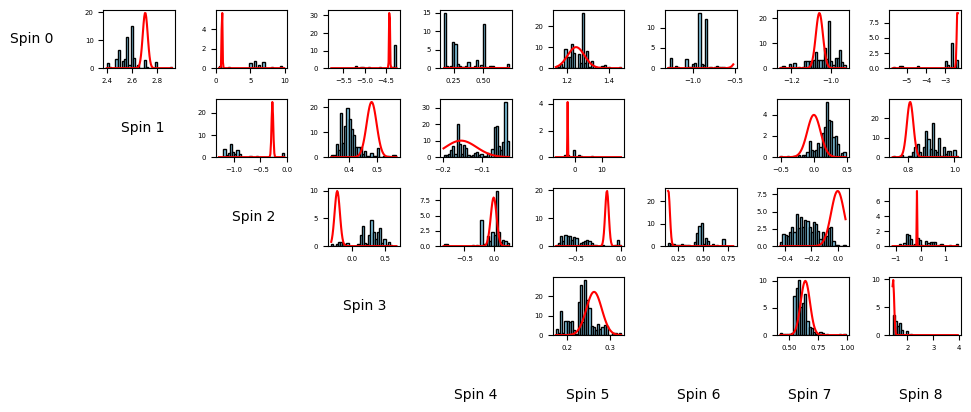

In [14]:
num_cols = len(a_par_data)

# Create figure and axes
fig = plt.figure(figsize=(10, 8))

# Plot each histogram in its respective subplot
for i in range(num_cols**2):
    y = i % num_cols
    x = i // num_cols
    if (x, y) not in couplings:
        continue
    ax = fig.add_subplot(num_cols, num_cols, i+1)
    cc = np.array([couplings[(x, y)][all_displacements_index[j,permutation_inv[x]],all_displacements_index[j,permutation_inv[y]]] for j in range(len(all_displacements_index))])
    _, bins, _ = ax.hist(cc, density = True, bins = 30,color='skyblue', edgecolor='black')
    xx = np.linspace(np.min(cc), np.max(cc), 100)
    ax.plot(xx, 1/np.sqrt(2*np.pi*WW_sigma[x, y]**2)*np.exp(-(xx-renormalized_data[x, y])**2/(2*WW_sigma[x, y]**2)), color = "red")
    ax.tick_params(axis='both', which='major', labelsize=5)
for i in range(num_cols):
    fig.text((i+0.5)/num_cols, 1-(min(i,4)+0.5)/ num_cols, f"Spin {i}", ha="center", va="center")

fig.tight_layout()

059

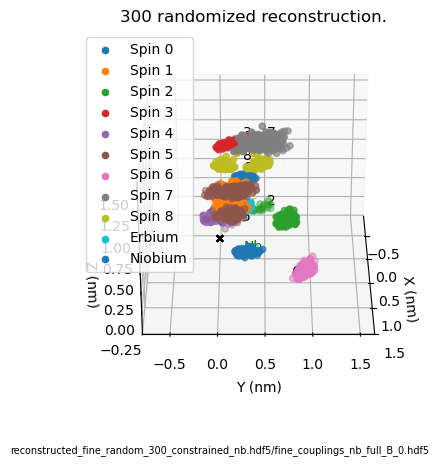

In [21]:

bound = 100

title_gif = title.replace(str(len(all_displacements_index)), str(bound))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title(title)

artists = []

for i in range(positions.shape[1]):
    artists.append(ax.scatter(new_pos[:,i,0].flatten(), new_pos[:,i,1].flatten(), new_pos[:,i,2].flatten(), label=f"Spin {i}"))

artists.append(ax.scatter(base_positions[:,0], base_positions[:,1], base_positions[:,2], color="black", marker = "x"))


artists.append(ax.scatter(rot_er[:,0]*1e9, rot_er[:,1]*1e9, rot_er[:,2]*1e9, label="Erbium"))
artists.append(ax.scatter(rot_nb[:,0]*1e9, rot_nb[:,1]*1e9, rot_nb[:,2]*1e9, label="Niobium"))
artists.append(ax.text(0.5*a*1e9, 0.5*a*1e9, 0.5*c*1e9, "Er", color="orange"))
artists.append(ax.text(0.5*a*1e9, 0.5*a*1e9 , 0 , "Nb", color="green"))

for i in range(len(base_positions)):
    artists.append(ax.text(base_positions[i,0]*1e9, base_positions[i,1]*1e9, base_positions[i,2]*1e9, str(i), color="black"))


ax.set_xlabel('X (nm)')
ax.set_ylabel('Y (nm)')
ax.set_zlabel('Z (nm)')
ax.axis('equal')

ax.legend()

ax.annotate(f'{file}/{couplings_file}',
            xy = (1.0, -0.2),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=7)

fig.tight_layout()


def animate(i):
    ax.view_init(azim=i)
    print(i, end = "\r")
    return (*artists,)


ani = animation.FuncAnimation(fig, animate, repeat=True, frames=360, interval=50)
writer = animation.PillowWriter(fps=15,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('random_scatter_300.gif', writer=writer)